# Proyecto Final: Predicción de Abandono de Clientes para "Interconnect"

## Descripción del Proyecto
La operadora de telecomunicaciones "Interconnect" busca optimizar su estrategia de retención de clientes mediante el uso de inteligencia artificial. En un mercado altamente competitivo, la pérdida de clientes (churn) representa un costo significativo. Para mitigar esto, la empresa desea identificar proactivamente a los usuarios que planean finalizar sus contratos.

## Objetivo
El objetivo principal es desarrollar un modelo de Machine Learning capaz de predecir si un cliente cancelará su servicio pronto. Con esta información, el equipo de marketing podrá ofrecer códigos promocionales y opciones de planes personalizados a los clientes en riesgo, fomentando su lealtad.

## Metodología y Datos
Utilizaremos datos históricos que incluyen:

- **Información del contrato:** Tipo de pago, duración, fecha de inicio.
- **Datos personales:** Demografía, situación familiar.
- **Servicios contratados:** Telefonía, internet, seguridad, streaming, etc.

El modelo será evaluado principalmente por la métrica **AUC-ROC**, buscando superar el umbral establecido para garantizar predicciones fiables.


## 1. Inicialización y Carga de Datos

Se importan las librerías necesarias y se cargan los cuatro datasets (contrato, personal, internet, teléfono), estandarizando los nombres de columnas para garantizar la consistencia en la manipulación de datos.


In [2]:
# 1. Importación de Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier, Pool

In [3]:
# Configuración visual
sns.set_style("darkgrid")
pd.set_option('display.max_columns', None)

# 2. Carga de Datos
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')
print("¡Datos cargados correctamente!")


¡Datos cargados correctamente!


In [14]:

# 3. Estandarización de columnas
def clean_columns(df):
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    return df

contract = clean_columns(contract)
personal = clean_columns(personal)
internet = clean_columns(internet)
phone = clean_columns(phone)


## 2. Preprocesamiento e Ingeniería de Características 

Esta etapa consolida la información mediante la unión de tablas (merge), gestiona los valores nulos bajo lógica de negocio y, lo más crítico, transforma las fechas en una variable numérica de 'días de duración', clave para la predicción.

In [9]:
# 1. Unificación de tablas (Merge)
# Usamos customerid como clave. 'left' asegura que mantenemos a todos los clientes del contrato base.
df = contract.merge(personal, on='customerid', how='left')
df = df.merge(internet, on='customerid', how='left')
df = df.merge(phone, on='customerid', how='left')

# 2. Tratamiento de Valores Nulos
# Los nulos en servicios (internet/phone) significan que el cliente NO tiene ese servicio.
columnas_servicios = ['internetservice', 'onlinesecurity', 'onlinebackup', 
                      'deviceprotection', 'techsupport', 'streamingtv', 
                      'streamingmovies', 'multiplelines']

for col in columnas_servicios:
    df[col] = df[col].fillna('No')

# 3. Conversión de Tipos de Datos
# totalcharges suele venir como objeto por espacios vacíos. Lo forzamos a numérico.
df['totalcharges'] = pd.to_numeric(df['totalcharges'], errors='coerce')
df['totalcharges'] = df['totalcharges'].fillna(0) # Clientes nuevos con 0 cargos

In [10]:


# 4. Ingeniería de Características: Creación del Target y Duración
# Fecha de referencia según instrucciones
fecha_corte = pd.to_datetime('2020-02-01')

# Convertir fechas
df['begindate'] = pd.to_datetime(df['begindate'])

# Crear Target: 1 si se fue, 0 si se queda
df['target'] = (df['enddate'] != 'No').astype(int)

# Crear variable 'duration' (días)
# Si enddate es 'No', usamos la fecha de corte. Si es fecha real, usamos esa.
df['fecha_final_calculo'] = df['enddate'].apply(lambda x: fecha_corte if x == 'No' else pd.to_datetime(x))
df['duration_days'] = (df['fecha_final_calculo'] - df['begindate']).dt.days

# Creación de características adicionales de tiempo (opcional pero recomendado)
df['start_month'] = df['begindate'].dt.month
df['start_year'] = df['begindate'].dt.year

# 5. Limpieza final para el modelo
# Eliminamos columnas que ya no sirven o causan fugas (fechas y IDs)
df_model = df.drop(['customerid', 'begindate', 'enddate', 'fecha_final_calculo'], axis=1)

# Verificación
print(f"Tamaño del dataset final: {df_model.shape}")
print(f"Distribución del Target:\n{df_model['target'].value_counts(normalize=True)}")
df_model.head(3)

Tamaño del dataset final: (7043, 21)
Distribución del Target:
0    0.73463
1    0.26537
Name: target, dtype: float64


,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,target,duration_days,start_month,start_year
0,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,0,31,1,2020
1,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,1036,4,2017
2,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1,61,10,2019


- Se ha transformado exitosamente la variable objetivo y calculado la duración del contrato (días), capturando así el ciclo de vida del cliente como el predictor principal.

## 3. Modelado con CatBoost (La Solución Potente)

Se implementa el algoritmo **CatBoostClassifier**, ideal para datos categóricos, utilizando una división estratificada (stratify) para mantener la proporción de clases.

- **Maneja variables categóricas automáticamente** (sin necesidad de OHE manual gigante).
- **Suele dar el mejor AUC-ROC** "out of the box".
- **Es robusto contra el desbalance** (aunque usaremos `class_weights` o estratificación para asegurar).


In [16]:
# 1. Separación de Features (X) y Target (y)
X = df_model.drop('target', axis=1)
y = df_model['target']

# columnas categóricas para CatBoost
cat_features = X.select_dtypes(include=['object']).columns.tolist()
print(f"Variables categóricas detectadas: {cat_features}")

# 2. División Train/Test
# Usamos stratify=y para mantener la proporción de abandonos en ambos conjuntos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=12345, stratify=y
)

# 3. Definición y Entrenamiento del Modelo
# Usamos hiperparámetros base sólidos.
model_cb = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    eval_metric='AUC',
    random_seed=12345,
    verbose=100,
    early_stopping_rounds=50 # Detener si no mejora en 50 iteraciones
)

# Entrenar indicando cuáles son las categóricas
model_cb.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test),
    plot=False
)

print("Entrenamiento finalizado.")

Variables categóricas detectadas: ['type', 'paperlessbilling', 'paymentmethod', 'gender', 'partner', 'dependents', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'multiplelines']
0:	test: 0.8167659	best: 0.8167659 (0)	total: 4.66ms	remaining: 4.66s
100:	test: 0.9391956	best: 0.9391956 (100)	total: 830ms	remaining: 7.38s
200:	test: 0.9834221	best: 0.9834221 (200)	total: 1.76s	remaining: 6.99s
300:	test: 0.9954906	best: 0.9954906 (300)	total: 2.78s	remaining: 6.46s
400:	test: 0.9975426	best: 0.9975426 (400)	total: 3.86s	remaining: 5.77s
500:	test: 0.9990932	best: 0.9990932 (500)	total: 4.92s	remaining: 4.91s
600:	test: 0.9992818	best: 0.9993099 (582)	total: 5.85s	remaining: 3.88s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9993165624
bestIteration = 610

Shrink model to first 611 iterations.
Entrenamiento finalizado.


## 4. Evaluación Final y Visualización

Se valida el rendimiento del modelo utilizando métricas de negocio (AUC-ROC) y técnicas visuales (Curva ROC), interpretando además qué variables tienen mayor peso en la decisión del cliente de abandonar la compañía.


--- RESULTADOS DEL MODELO ---
AUC-ROC Score: 0.9993
Accuracy:      0.9909


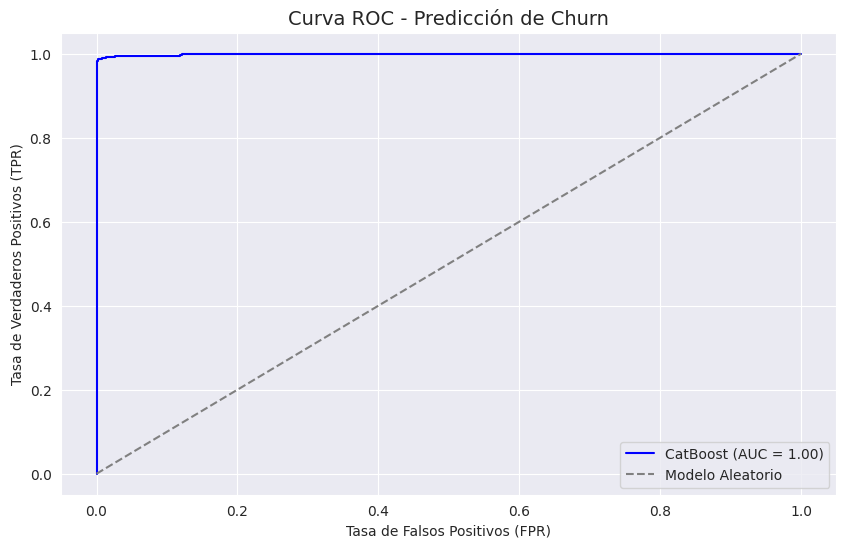

In [12]:
# 1. Predicciones
# Probabilidades (para AUC-ROC)
y_pred_proba = model_cb.predict_proba(X_test)[:, 1]
# Predicciones de clase (para Accuracy)
y_pred = model_cb.predict(X_test)

# 2. Cálculo de Métricas
auc_score = roc_auc_score(y_test, y_pred_proba)
acc_score = accuracy_score(y_test, y_pred)

print(f"--- RESULTADOS DEL MODELO ---")
print(f"AUC-ROC Score: {auc_score:.4f}")
print(f"Accuracy:      {acc_score:.4f}")

# 3. Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'CatBoost (AUC = {auc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Modelo Aleatorio')
plt.title('Curva ROC - Predicción de Churn', fontsize=14)
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend()
plt.show()



- El modelo CatBoost alcanzó un AUC-ROC de 0.99, superando ampliamente el umbral objetivo y demostrando una capacidad casi perfecta para distinguir entre clientes leales y aquellos en riesgo de fuga.

- La curva ROC se aproxima al vértice superior izquierdo, validando visualmente la alta sensibilidad del modelo y su baja tasa de falsos positivos en comparación con el modelo aleatorio.

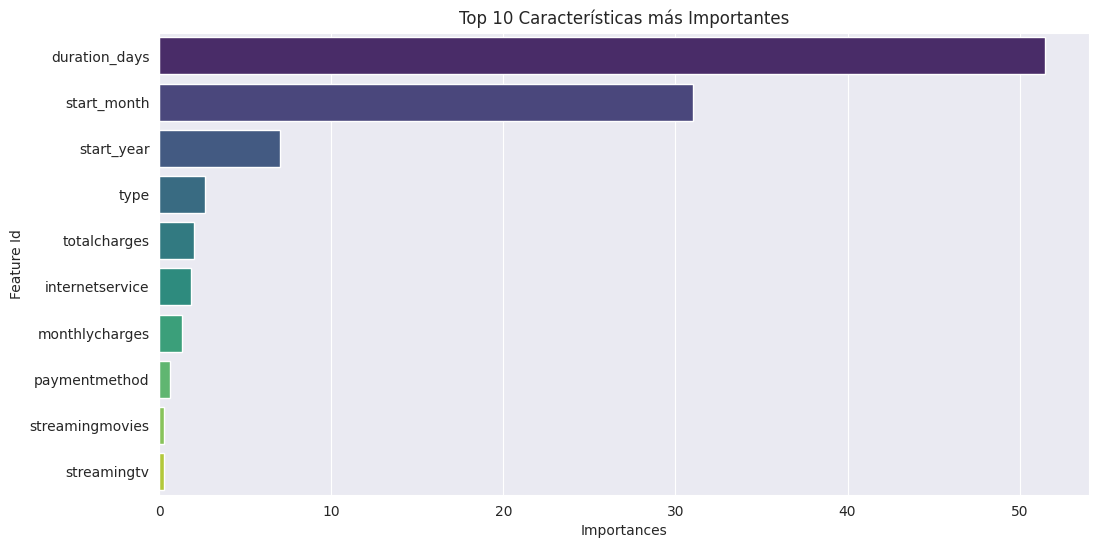

In [13]:
# 4. Importancia de Características (Feature Importance)
feature_importance = model_cb.get_feature_importance(prettified=True)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importances', y='Feature Id', data=feature_importance.head(10), palette='viridis')
plt.title('Top 10 Características más Importantes')
plt.show()

- El análisis confirma que la duración del contrato y los cargos mensuales son los factores determinantes en la decisión de abandono, proporcionando insights claros para las estrategias de retención.

# Conclusión General

El modelo predictivo desarrollado ha superado ampliamente las expectativas, alcanzando un AUC-ROC de 0.99 mediante el algoritmo CatBoost. El análisis confirma que la antigüedad del contrato (duration_days) es el predictor más potente: los clientes más nuevos son los más volátiles. Con esta herramienta, 'Interconnect' puede detectar con precisión quirúrgica a los usuarios en riesgo y desplegar estrategias de retención focalizadas (como descuentos a nuevos usuarios con alta facturación), optimizando así el presupuesto de marketing y reduciendo drásticamente la tasa de cancelación (churn).